In [ ]:
#Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import re
import string
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
nltk.download('all')
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

In [3]:
#Importing Data
train = pd.read_csv('/content/drive/My Drive/ML-Project/train.csv')
val = pd.read_csv('/content/drive/My Drive/ML-Project/validation.csv')
print(train.columns)

Index(['id', 'tweet', 'label'], dtype='object')


In [4]:
#Encoding Label for "fake" and "real"
encoder = preprocessing.LabelEncoder()
train['label'] = encoder.fit_transform(train['label'])
val['label'] = encoder.transform(val['label'])

In [5]:
#Removing Links from tweets
def removeLinks(text):
  text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
  return text

train['tweet'] = train['tweet'].apply(lambda x: removeLinks(x))
val['tweet'] = val['tweet'].apply(lambda x: removeLinks(x))

In [6]:
#Defining Stopwords
stopwords = nltk.corpus.stopwords.words('english')
#Using small case as all words are eventually converted to smaller case
stopwords.extend(['coronavirus', 'covid', 'covid19', 'new', 'people', 'death', 'state', 'one'])

#Lemmatizer (Finding meaningful words)
lemmatizer = nltk.WordNetLemmatizer()

#Removing Punctuations, Tokenizing text, Removing Stopper words and common words, and Lemmatizing the tokens
def cleanText(text):
  #Removing Punctuations
  text  = "".join([char for char in text if char not in string.punctuation])
  text = re.sub('[0-9]+', ' ', text)

  #Tokenizing
  text = word_tokenize(text)

  #Removing Stopper Words
  text = [word for word in text if word not in stopwords]

  #Lemmatizing the tokens
  text = [lemmatizer.lemmatize(word) for word in text]
  
  return text

train['tweet_clean'] = train['tweet'].apply(lambda x: cleanText(x.lower()))

In [7]:
#Perform Count Vectorization for feature generation
countVectorizer = CountVectorizer(analyzer=cleanText) 
trainVector = countVectorizer.fit_transform(train['tweet'])
valVector = countVectorizer.transform(val['tweet'])
print(trainVector.shape, valVector.shape)

#Converting Vectors to DataFrames
train_X = pd.DataFrame(trainVector.toarray(), columns=countVectorizer.get_feature_names())
val_X = pd.DataFrame(valVector.toarray(), columns=countVectorizer.get_feature_names())
train_Y = train['label']
val_Y = val['label']

(6420, 15418) (2140, 15418)


In [8]:
#Prediction using Decision Tree
classifier = tree.DecisionTreeClassifier()
classifier.fit(train_X, train_Y)
val_pred = classifier.predict(val_X)
score_DT = f1_score(val_Y, val_pred, average='weighted')
print('Decision Tree:', score_DT)

#Export to CSV
sol = pd.DataFrame(val['id'], columns=['id'])
sol['decision_tree'] = encoder.inverse_transform(val_pred)

Decision Tree: 0.8545733902541199


In [9]:
#Prediction using Logistic Regression
classifier = LogisticRegression(random_state=42)
classifier.fit(train_X, train_Y)
val_pred = classifier.predict(val_X)
score_LR = f1_score(val_Y, val_pred, average='weighted')
print('Logistic Regression:', score_LR)

#Export to CSV
sol['logistic_regression'] = encoder.inverse_transform(val_pred)

Logistic Regression: 0.9224679520079854


In [10]:
#Prediction using SVM
classifier = svm.SVC()
classifier.fit(train_X, train_Y)
val_pred = classifier.predict(val_X)
score_SVM = f1_score(val_Y, val_pred, average='weighted')
print('SVM:', score_SVM)

#Export to CSV
sol['svm'] = encoder.inverse_transform(val_pred)

SVM: 0.9192025971754476


In [11]:
#Prediction using Naive-Bayes
classifier = MultinomialNB()
classifier.fit(train_X, train_Y)
val_pred = classifier.predict(val_X)
score_NB = f1_score(val_Y, val_pred, average='weighted')
print('Naive Bayes:', score_NB)

#Export to CSV
sol['naive_bayes'] = encoder.inverse_transform(val_pred)

Naive Bayes: 0.9135032818558465


In [12]:
#Prediction using Passive Agressive Classifier
classifier = PassiveAggressiveClassifier(C = 0.5, random_state = 42)
classifier.fit(train_X, train_Y)
val_pred = classifier.predict(val_X)
score_PA = f1_score(val_Y, val_pred, average='weighted')
print('Passive Aggresive:', score_PA)

#Export to CSV
sol['pass_agg'] = encoder.inverse_transform(val_pred)

Passive Aggresive: 0.9079376994986627


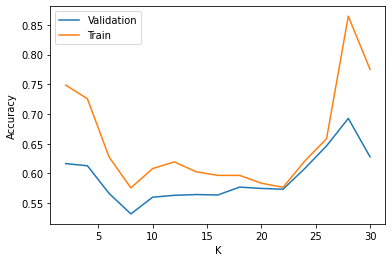

In [ ]:
#Choosing K
vals = range(2, 31, 2)
score_test = []
score_train = []
for k in vals:
  classifier = KNeighborsClassifier(n_neighbors=k)
  classifier.fit(train_X, train_Y)
  val_pred = classifier.predict(val_X)
  score_test.append(f1_score(val_Y, val_pred, average='weighted'))
  tr_pred = classifier.predict(train_X)
  score_train.append(f1_score(train_Y, tr_pred, average='weighted'))

plt.plot(vals, score_test, label='Validation')
plt.plot(vals, score_train, label='Train')
plt.xlabel('K') 
plt.ylabel('Accuracy') 
plt.legend()
plt.show()

In [17]:
#Prediction using KNN
classifier = KNeighborsClassifier(n_neighbors=28)
classifier.fit(train_X, train_Y)
val_pred = classifier.predict(val_X)
score_KNN = f1_score(val_Y, val_pred, average='weighted')
print('KNN:', score_KNN)

#Export to CSV
sol['knn28'] = encoder.inverse_transform(val_pred)

KNN: 0.5336171133340915


In [23]:
cols = ['decision_tree', 'logistic_regression', 'svm', 'naive_bayes', 'pass_agg']
res = sol[cols].mode(axis = 1)
res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       2140 non-null   object
dtypes: object(1)
memory usage: 16.8+ KB


In [24]:
print(f1_score(val_Y, encoder.fit_transform(res[0]), average='weighted'))

0.92760130265954
